# Données COVID-19 Australie: EDA

Test évaluation pour le poste Inria / AP-HP - notebook 1

In [1]:
!pip install pycountry_convert

     |████████████████████████████████| 10.1 MB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 231 kB 44.4 MB/s eta 0:00:01
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746863 sha256=68541fc69a554eefce30b44be958aae312f9747e640299a7c541cbe24baadc23
  Stored in directory: /home/marco/.cache/pip/wheels/09/eb/0d/4ee773c6a4aadc2a43cb5c1d07f268f13c4cdc0eec88e7c1ef
Successfully built pycountry


## 1. Importation des données et des librairies python

In [89]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
#%matplotlib inline
import seaborn as sns
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pycountry_convert as pc
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
from plotly.subplots import make_subplots
import folium
from PIL import Image

In [7]:
df_cases = pd.read_csv("australia_covid.csv")

In [127]:
df_pop = pd.read_csv("population.csv")

In [8]:
print(df_cases.shape)
del df_cases['Unnamed: 0']
df_cases.head()


(6389, 15)


,patient_id,pcr,pcr_n,given_name,surname,street_number,address_1,suburb,postcode,age,phone_number,address_2,birth_year,state
0,347667,Negative,0,sebastian,mchenry,12.0,mundawari circuit,swan view,4551,28,08 61083524,ocean star villas,1990,wa
1,708481,Positive,1,sarah,rellos,20.0,torres street,bribie island,3199,77,02 73197286,missing,1943,sa
2,148825,Negative,0,chloe,brammy,238.0,fitchett street,carnegie,3280,19,02 48826642,missing,1954,qld
3,150081,Negative,0,charlie,missing,6.0,clark close,south melbourne,2602,35,03 24096098,talawa,1975,qld
4,876796,Negative,0,alexander,dixon,11.0,missing,torquay,2142,102,04 21654709,woodberry vlge,1918,wa


## 2. Analyse exploratoire des données (EDA)

### 2.1 Age

#### 2.1.1 Tranches d'age

In [28]:
# Incidence by age segments: define the segments with a 10 years step
bins = [-1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 111]
# labels
group_names = ['< 20','11-20','21-30','31-40', '41-50','51-60','61-70','71-80','81-90','91-100', 'over_100']


In [29]:
# Build column for age segments
categories = pd.cut(df_cases['age'], bins, labels=group_names)
# Add categories as column in dataframe
df_cases['age_segment'] = categories


< 20         248
11-20        456
21-30       2564
31-40       1963
41-50        212
51-60        105
61-70        105
71-80        127
81-90        131
91-100       123
over_100     135
Name: age_segment, dtype: int64

#### 2.1.2 Statistiques par tranche d'age

In [35]:
gb_age = df_cases.groupby(['age_segment']).agg({'pcr_n':'sum', 'age':'count'}).reset_index()
gb_age = gb_age.rename({'pcr_n':'total_positives', 'age':'total_tests'}, axis=1)

In [38]:
gb_age['percentage_positives'] = np.round((gb_age['total_positives']/gb_age['total_tests'])*100, 1)
gb_age

,age_segment,total_positives,total_tests,percentage_positives
0,< 20,71,248,28.6
1,11-20,98,456,21.5
2,21-30,629,2564,24.5
3,31-40,486,1963,24.8
4,41-50,40,212,18.9
5,51-60,19,105,18.1
6,61-70,23,105,21.9
7,71-80,33,127,26.0
8,81-90,29,131,22.1
9,91-100,31,123,25.2


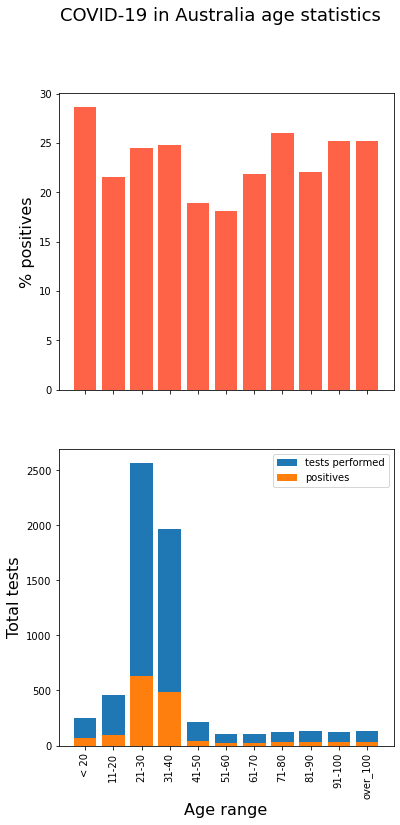

In [75]:
plt.figure(figsize= (6,12))
plt.suptitle('COVID-19 in Australia age statistics', fontsize=18)
plt.subplot(211)
plt.bar(gb_age["age_segment"], gb_age["percentage_positives"], color = "tomato")
#plt.plot(timerange,y_e, '--', color = 'orange', label = 'gaussian fit') 
#plt.title('Covid-19 incidence by age segment')
plt.ylabel('% positives', fontsize = 16)
plt.xticks(gb_age["age_segment"]," ")
plt.subplot(212)
#gb_age.plot.bar(x="age_segment", y=["total_tests", "total_positives"], stacked=True)
plt.bar(gb_age["age_segment"], gb_age["total_tests"], label = 'tests performed')
plt.bar(gb_age["age_segment"], gb_age["total_positives"], label = 'positives')
plt.legend()
plt.ylabel('Total tests',fontsize = 16)
plt.xlabel('Age range',fontsize = 16)
plt.xticks(rotation=90)
plt.show()

### 2.2 États

#### 2.2.1 Groupement par état

In [84]:
gb_state = df_cases.groupby(['state']).agg({'pcr_n':'sum', 'patient_id':'count'}).reset_index()
delete_row = gb_state[gb_state["state"]=='missing'].index # drop missing values for the country
gb_state = gb_state.drop(delete_row)
gb_state = gb_state.rename({'pcr_n':'total_positives', 'patient_id':'total_tests'}, axis=1)

In [85]:
gb_state

,state,total_positives,total_tests
0,act,25,101
2,nsw,499,2122
3,nt,3,36
4,qld,315,1271
5,sa,106,494
6,tas,41,192
7,vic,405,1573
8,wa,154,597


#### 2.2.2 Population par état
https://www.worldatlas.com/articles/the-largest-states-and-territories-of-australia.html

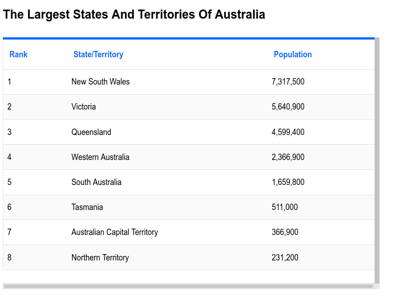

In [96]:
im = Image.open("state_population.png")
au_population = im.resize((400,300))
au_population

In [135]:
#df_pop = pd.DataFrame(population)
df_pop1 = df_pop.sort_values(by=['state'], inplace=True)
ls1 = df_pop['state'].tolist()
ls2 = df_pop['population'].tolist()

In [136]:
gb_state['state_full_name'] = ls1
gb_state['population'] = ls2

#### 2.2.3 Statistiques par état

In [140]:
gb_state['percentage_population_tested'] = np.round((gb_state['total_tests']/gb_state['population'])*100, 3)

In [141]:
gb_state['percentage_positives'] = np.round((gb_state['total_positives']/gb_state['total_tests'])*100, 1)

In [144]:
gb_state['percentage_population_positive'] = np.round((gb_state['total_positives']/gb_state['population'])*100, 4)
gb_state

,state,total_positives,total_tests,state_full_name,population,percentage_population_tested,percentage_positives,percentage_population_positive
0,act,25,101,Australian Capital Territory,366900,0.028,24.8,0.0068
2,nsw,499,2122,New South Wales,7317500,0.029,23.5,0.0068
3,nt,3,36,Northern Territory,231200,0.016,8.3,0.0013
4,qld,315,1271,Queensland,4599400,0.028,24.8,0.0068
5,sa,106,494,South Australia,1659800,0.030,21.5,0.0064
6,tas,41,192,Tasmania,511000,0.038,21.4,0.0080
7,vic,405,1573,Victoria,5640900,0.028,25.7,0.0072
8,wa,154,597,Western Australia,2366900,0.025,25.8,0.0065


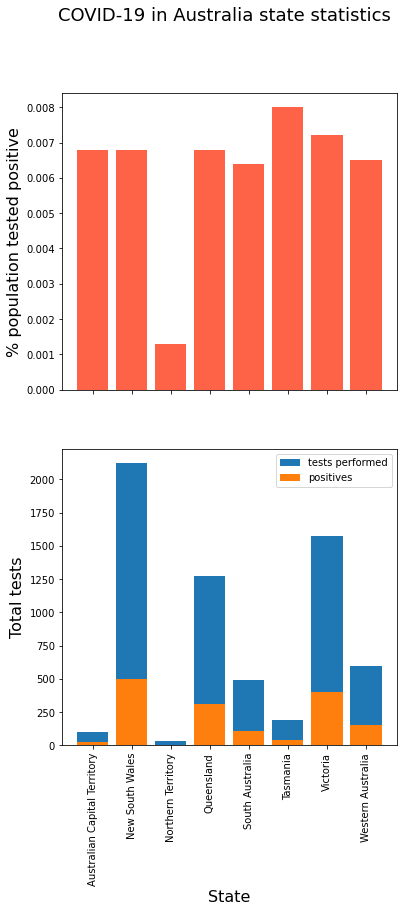

In [200]:
plt.figure(figsize= (6,12))
plt.suptitle('COVID-19 in Australia state statistics', fontsize=18)
plt.subplot(211)
plt.bar(gb_state["state_full_name"], gb_state["percentage_population_positive"], color = "tomato")

plt.ylabel('% population tested positive', fontsize = 16)
plt.xticks(gb_state["state_full_name"]," ")
plt.subplot(212)
#gb_age.plot.bar(x="age_segment", y=["total_tests", "total_positives"], stacked=True)
plt.bar(gb_state["state_full_name"], gb_state["total_tests"], label = 'tests performed')
plt.bar(gb_state["state_full_name"], gb_state["total_positives"], label = 'positives')
plt.legend()
plt.ylabel('Total tests',fontsize = 16)
plt.xlabel('State',fontsize = 16)
plt.xticks(rotation=90)
plt.show()

In [193]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/rowanhogan/australian-states/master/states.geojson') as response:
    state_geo = json.load(response)# Read the geojson data with Australia's state borders from github

In [198]:
map1 = folium.Map(location=[-25.8, 136.8698],tiles='cartodbpositron', zoom_start=5)
tests_proportion = gb_state[['state_full_name','percentage_population_tested']]
tiles = ['stamenwatercolor', 'cartodbpositron', 'openstreetmap', 'stamenterrain']

for tile in tiles:
    folium.TileLayer(tile).add_to(map1)
    
choropleth = folium.Choropleth(
    geo_data = state_geo,
    name = 'choropleth',
    data = tests_proportion,
    columns = ['state_full_name','percentage_population_tested'],
    key_on = 'feature.properties.STATE_NAME',
    fill_color = 'BuPu',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = '% population tested for COVID-19', # (% tested) in 2020
    highlight = True
).add_to(map1)
map1

In [197]:
map2 = folium.Map(location=[-25.8, 136.8698],tiles='cartodbpositron', zoom_start=5)
cases_proportion = gb_state[['state_full_name','percentage_positives']]
tiles = ['stamenwatercolor', 'cartodbpositron', 'openstreetmap', 'stamenterrain']

for tile in tiles:
    folium.TileLayer(tile).add_to(map2)
    
choropleth = folium.Choropleth(
    geo_data = state_geo,
    name = 'choropleth',
    data = cases_proportion,
    columns = ['state_full_name','percentage_positives'],
    key_on = 'feature.properties.STATE_NAME',
    fill_color = 'YlGn',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = '% positives COVID-19', # (% positives) in 2020
    highlight = True
).add_to(map2)
map2